In [2]:
pip install alpha_vantage

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from alpha_vantage.timeseries import TimeSeries
# from pprint import pprint
import requests
from datetime import datetime

# 1

In [4]:
class ScriptData:
    def __init__(self):
        self.data = {}
    
    def fetch_intraday_data(self, script):
        api_key = 'TCWNU2ZM9THSTMQ1'
        url = f"https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol={script}&interval=5min&apikey={api_key}"
        response = requests.get(url)
        if response.status_code == 200:
            self.data[script] = response.json()
        else:
            raise Exception("Failed to fetch data from Alpha Vantage")
    
    def convert_intraday_data(self, script):
        raw_data = self.data[script]["Time Series (5min)"]
        data = []
        for timestamp, values in raw_data.items():
            data.append([pd.Timestamp(timestamp), float(values["1. open"]), float(values["2. high"]), float(values["3. low"]), float(values["4. close"]), int(values["5. volume"])])
        self.data[script] = pd.DataFrame(data, columns=["timestamp", "open", "high", "low", "close", "volume"])
    
    def __getitem__(self, script):
        return self.data[script]
    
    def __setitem__(self, script, df):
        self.data[script] = df
    
    def __contains__(self, script):
        return script in self.data

In [5]:
script_data = ScriptData()

In [6]:
script_data.fetch_intraday_data('GOOGL')
script_data.convert_intraday_data('GOOGL')

In [7]:
script_data['GOOGL']

,timestamp,open,high,low,close,volume
0,2023-02-14 20:00:00,94.180,94.1800,94.110,94.1200,9174
1,2023-02-14 19:55:00,94.230,94.2300,94.180,94.1800,2882
2,2023-02-14 19:50:00,94.240,94.2400,93.500,93.5000,15924
3,2023-02-14 19:45:00,94.260,94.2899,94.200,94.2000,5486
4,2023-02-14 19:40:00,94.260,94.3200,94.250,94.3200,5043
...,...,...,...,...,...,...
95,2023-02-14 12:00:00,92.460,92.7300,92.450,92.6607,368689
96,2023-02-14 11:55:00,92.550,92.5700,92.270,92.4679,385199
97,2023-02-14 11:50:00,92.330,92.6300,92.305,92.5500,683503
98,2023-02-14 11:45:00,92.360,92.4550,92.260,92.3531,604495


In [8]:
script_data.fetch_intraday_data('AAPL')
script_data.convert_intraday_data('AAPL')

In [9]:
script_data['AAPL']

,timestamp,open,high,low,close,volume
0,2023-02-14 20:00:00,152.79,152.850,152.76,152.84,9429
1,2023-02-14 19:55:00,152.75,152.770,152.73,152.77,3596
2,2023-02-14 19:50:00,152.75,152.760,152.70,152.71,4770
3,2023-02-14 19:45:00,152.84,152.870,152.75,152.76,7379
4,2023-02-14 19:40:00,152.87,152.870,152.84,152.84,1795
...,...,...,...,...,...,...
95,2023-02-14 12:00:00,151.56,151.830,151.36,151.70,518882
96,2023-02-14 11:55:00,151.53,151.600,151.17,151.55,496456
97,2023-02-14 11:50:00,151.13,151.720,151.10,151.54,494145
98,2023-02-14 11:45:00,151.35,151.386,151.04,151.14,490943


In [10]:
'GOOGL' in script_data

True

In [11]:
'AAPL' in script_data

True

In [12]:
'NVDA' in script_data

False

# 2

In [13]:
def indicator1(df, timeperiod = 5):
    close_data = df["close"]
    indicator = close_data.rolling(window=timeperiod).mean()
    return pd.DataFrame({"timestamp": df["timestamp"], "indicator": indicator})

In [14]:
indicator1(script_data['GOOGL'], timeperiod = 5)

,timestamp,indicator
0,2023-02-14 20:00:00,NaN
1,2023-02-14 19:55:00,NaN
2,2023-02-14 19:50:00,NaN
3,2023-02-14 19:45:00,NaN
4,2023-02-14 19:40:00,94.06400
...,...,...
95,2023-02-14 12:00:00,92.79670
96,2023-02-14 11:55:00,92.69828
97,2023-02-14 11:50:00,92.60128
98,2023-02-14 11:45:00,92.53490


In [15]:
indicator1(script_data['AAPL'], timeperiod = 5)

,timestamp,indicator
0,2023-02-14 20:00:00,NaN
1,2023-02-14 19:55:00,NaN
2,2023-02-14 19:50:00,NaN
3,2023-02-14 19:45:00,NaN
4,2023-02-14 19:40:00,152.784
...,...,...
95,2023-02-14 12:00:00,151.840
96,2023-02-14 11:55:00,151.746
97,2023-02-14 11:50:00,151.660
98,2023-02-14 11:45:00,151.522


# 3

In [16]:
import pandas as pd
pd.options.mode.chained_assignment = None

class Strategy:

    def __init__(self, script_name):
        self.script_name = script_name
        self.script_data = ScriptData()
        if script_name not in self.script_data:
            self.script_data.fetch_intraday_data(script_name)
            self.script_data.convert_intraday_data(script_name)
    def get_script_data(self):
        self.df = self.script_data[self.script_name]
    
    def get_signals(self):
        # Fetch intraday historical data
        script_data = ScriptData()        
        # Compute indicator data
        indicator_data = indicator1(self.df)
        # Generate signals DataFrame
        signals = pd.DataFrame({'timestamp': self.df['timestamp'], 'signal': [''] * len(self.df)})
        for i in range(len(self.df)):
          if indicator_data.shift()['indicator'][i] != None:
            if indicator_data.shift()['indicator'][i] < self.df['close'][i]:
              signals['signal'][i] = 'BUY'
            else:
              signals['signal'][i] = 'SELL'
          else:
            signals['signal'][i] = 'No Signal'
        
        # Print signals DataFrame
        print(signals)

In [17]:
strategy = Strategy('NVDA')

In [18]:
strategy.get_script_data()

In [19]:
strategy.get_signals()

             timestamp signal
0  2023-02-14 20:00:00   SELL
1  2023-02-14 19:55:00   SELL
2  2023-02-14 19:50:00   SELL
3  2023-02-14 19:45:00   SELL
4  2023-02-14 19:40:00   SELL
..                 ...    ...
95 2023-02-14 12:05:00   SELL
96 2023-02-14 12:00:00   SELL
97 2023-02-14 11:55:00   SELL
98 2023-02-14 11:50:00   SELL
99 2023-02-14 11:45:00   SELL

[100 rows x 2 columns]


# 4

In [20]:
!pip install mplfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.1/73.1 KB 3.0 MB/s eta 0:00:00


In [21]:
!pip install pyalgotrading

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [22]:
!pip install pypi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for pypi: filename=pypi-2.1-py3-none-any.whl size=1354 sha256=836d363fb766f54058439352711789799f0a3054d1cc784660f36987ea1bf303
  Stored in directory: /root/.cache/pip/wheels/6e/bb/35/2b31808160dec7d2186ec14eca0b52c3f5a337d1aa40d87f59
Successfully built pypi


In [45]:
import mplfinance as fplt
import pyalgotrading as pat
from matplotlib import dates

In [46]:
# import pyalgotrading.plotting as plt

# create a Strategy instance and fetch the required data
# strategy = Strategy('AAPL')

# strategy.get_script_data()
df1 = script_data['GOOGL']

# df1 = df1.loc['timestamp']
# df = strategy.script_name.convert_intraday_data()
# df1.index = pd.DatetimeIndex(df1['timestamp'])
# compute indicator data
# indicator_data = indicator1(script_data['GOOGL'], timeperiod = 5)

# ap = mpf.make_addplot(indicator_data)

# mpl(df1, type = "candle")

# plt.show()

In [47]:
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz 
!tar xvzf ta-lib-0.4.0-src.tar.gz
import os
os.chdir('ta-lib') # Can't use !cd in co-lab
!./configure --prefix=/usr
!make
!make install
os.chdir('../')
!pip install TA-Lib

--2023-02-15 14:21:31--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 204.68.111.105
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|204.68.111.105|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2023-02-15 14:21:31--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: http://cytranet.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2023-02-15 14:21:31--  http://cytranet.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving cytranet.dl.s

In [48]:
import talib

In [49]:
df1["SMA"] = talib.SMA(df1.close, timeperiod=5)

In [50]:
df1.head()

,timestamp,open,high,low,close,volume,SMA,RSI,EMA
0,2023-02-14 20:00:00,94.18,94.1800,94.11,94.12,9174,NaN,NaN,NaN
1,2023-02-14 19:55:00,94.23,94.2300,94.18,94.18,2882,NaN,NaN,NaN
2,2023-02-14 19:50:00,94.24,94.2400,93.50,93.50,15924,NaN,NaN,NaN
3,2023-02-14 19:45:00,94.26,94.2899,94.20,94.20,5486,NaN,NaN,NaN
4,2023-02-14 19:40:00,94.26,94.3200,94.25,94.32,5043,94.064,NaN,94.064


In [54]:
df1.index = pd.DatetimeIndex(df1['timestamp'])

In [56]:
df1_small = df1[50:]

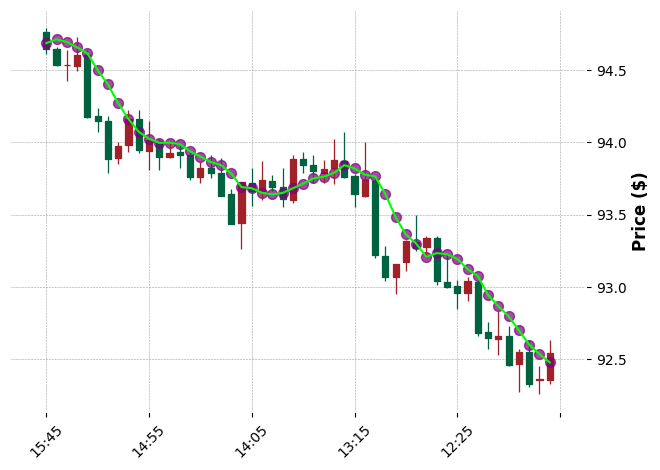

In [57]:
sma1 = fplt.make_addplot(df1_small["SMA"], color="lime", width=1.5)
sma2 = fplt.make_addplot(df1_small["SMA"], type="scatter", color="purple", marker="o",
                         alpha=0.7, markersize=50)

fplt.plot(
            df1_small,
            type='candle',
            addplot = [sma1, sma2],
            style='charles',
            ylabel='Price ($)',
            )